# Post-Review-Synthetic-Data-V3

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import table

### Defining functions

In [ ]:
def label(df):    
    # label data
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    
def preprocess(df):
    n_most_common_words = 1000
    max_len = 130

 
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)


    tokenizer.fit_on_texts(df['OPCODE'].values)

    # # Transforms each text in texts in a sequence of integers.
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    # sequences = tokenizer.texts_to_sequences(tt)

    #Find number of unique words/tokens
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #pad sequences with zeros in front to make them all maxlen
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def dftoXY(df):
    # Save test X and y
    X_test = preprocess(df)
    # label data
    label(df)
    print(pd.value_counts(df['LABEL']))
    y_test = to_categorical(df['LABEL'], num_classes=2)
    return X_test, y_test    

def XandY(posdf, negdf):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)

    dfset['LABEL'] = 0

    #One-hot encode the lab
    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    # df_train.head()

    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    # for sm.fit_sample
    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

### Loading the dataset

In [ ]:
# Loading and reading csv input data 
dataset = '/content/gdrive/My Drive/for test and train/assets/clean_train.csv'
data = pd.read_csv(dataset, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
data.head()

,ADDRESS,OPCODE,CATEGORY
0,0,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
1,1,60 60 52 36 15 61 57 63 7c 60 35 04 16 63 81 1...,1 0 0 0
2,2,36 60 80 37 60 60 36 60 73 60 5a 03 f4 15 60 5...,1 0 0 0
3,3,60 60 52 5b fe 00 a1 65 20 65 0a 41 82 86 95 5...,1 0 0 0
4,4,60 60 52 36 15 61 57 63 60 60 0a 60 35 04 16 6...,1 0 0 0


### Checking the target classes

In [ ]:
pd.value_counts(data['CATEGORY'])

1 0 0 0    27343
0 0 0 1     4914
0 0 1 0     1240
0 1 0 0     1026
Name: CATEGORY, dtype: int64

### Plot unbalanced

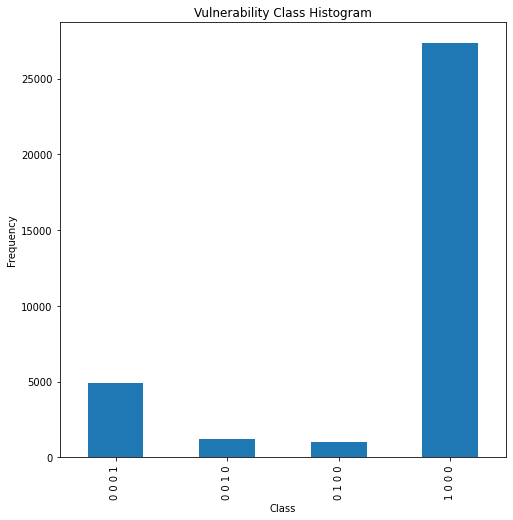

In [ ]:
fig = plt.figure()
count_classes = pd.value_counts(data['CATEGORY'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Vulnerability Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
fig.set_size_inches(8, 8)
plt.show()
# fig.savefig('./figures/clean_train_unbalanced_distr.png', dpi=300) #, bbox_inches='tight'

### Dividing data into vulnerable and non-vulnerable

In [ ]:
# shuffled = data.reindex(np.random.permutation(data.index))
shuffled = data

# shuffled = data
n = shuffled[shuffled['CATEGORY'] == '1 0 0 0'] # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0'] # suicidal
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0'] # prodigal
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1'] # greedy
sp = shuffled[shuffled['CATEGORY'] == '0 1 1 0'] # suicidal and prodigal

### Plot two class unbalanced

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


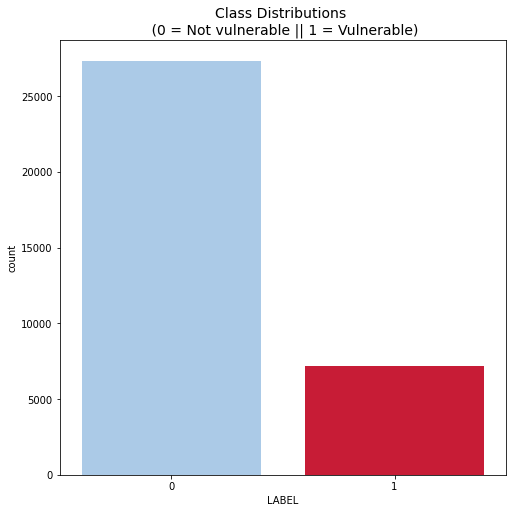

In [ ]:
concated = pd.concat([n,s,p,g,sp], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

#One-hot encode the lab
concated.loc[concated['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1

import seaborn as sns
fig = plt.figure()
# colors = ["#0101DF", "#DF0101"]
colors = ["#A1CAF1", "#E30022"]

sns.countplot('LABEL', data=concated, palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)
# fig.savefig('./figures/clean_train_unbalanced2class.png', dpi=300) #, bbox_inches='tight'

### Dividing data into train, validation, and test

In [ ]:
# ========== set of vul contracts ========== 
# shuffle positives dataset
positives = pd.concat([s,p,g,sp])
positives_shuf = positives.sample(frac=1, random_state=39, replace=False)
print(len(positives_shuf))

# split positives dataset into train, val, and test
proportion_train = 0.64 #0.7 
proportion_val = 0.16 #0.1 
proportion_test = 0.2 #0.20

num_pos_train = round(len(positives_shuf) * proportion_train)
num_pos_val = round(len(positives_shuf) * proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train] 
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train+num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train+num_pos_val):]

# print(len(pos_train))
# print(len(pos_val))
# print(len(pos_test))

7180


In [ ]:
# ========== set of non-vul contracts ========== 
# # shuffle set n
n_shuf = n.sample(frac=1, random_state=39, replace=False)

# set number of samples in each set
num_neg_train = 300 #30000 #11000
num_neg_val = round(((num_neg_train)/proportion_train)*proportion_val)
num_neg_test = round(((num_neg_train)/proportion_train)*proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train+num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train+num_neg_val):(num_neg_train+num_neg_val+num_neg_test)]
# neg_notused = n_shuf.iloc[(num_neg_train+num_neg_val+num_neg_test):]
# print("Number of negative samples not used: ", len(neg_notused))

# print(len(neg_train))
# print(len(neg_val))
# print(len(neg_test))

### Resampling samples

### Resampling samples

In [ ]:
# Prepare train set 
X_train, ytrain_labels = XandY(pos_train, neg_train)
# Prepare validation set 
X_val, yval_labels = XandY(pos_val, neg_val)
# Prepare test set 
X_test, ytest_labels = XandY(pos_test, neg_test)

Found 150 unique tokens.
1    4595
0     300
Name: LABEL, dtype: int64
Shape of X: (4895, 130)
Shape of y: (4895, 1)
Found 150 unique tokens.
1    1149
0      75
Name: LABEL, dtype: int64
Shape of X: (1224, 130)
Shape of y: (1224, 1)
Found 150 unique tokens.
1    1436
0      94
Name: LABEL, dtype: int64
Shape of X: (1530, 130)
Shape of y: (1530, 1)


In [ ]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", ytrain_labels.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", yval_labels.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", ytest_labels.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(ytrain_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(ytrain_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(yval_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(yval_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(ytest_labels==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytest_labels==0)))

Number transactions X_train dataset:  (4895, 130)
Number transactions y_train dataset:  (4895, 1)
Number transactions X_val dataset:  (1224, 130)
Number transactions y_val dataset:  (1224, 1)
Number transactions X_test dataset:  (1530, 130)
Number transactions y_test dataset:  (1530, 1)
Before OverSampling, counts of label '1': [4595]
Before OverSampling, counts of label '0': [300]
Before OverSampling, counts of label '1': [1149]
Before OverSampling, counts of label '0': [75]
Before OverSampling, counts of label '1': [1436]
Before OverSampling, counts of label '0': [94] 



In [ ]:
# ============ Resample ============ 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=39)
X_train_res, y_train_res = sm.fit_sample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_sample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_sample(X_test, ytest_labels.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(X_val_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(y_val_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(X_test_res.shape))
print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

print("After OverSampling, counts of train label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of train label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of val label '1': {}".format(sum(y_val_res==1)))
print("After OverSampling, counts of val label '0': {}".format(sum(y_val_res==0)))
print("After OverSampling, counts of test label '1': {}".format(sum(y_test_res==1)))
print("After OverSampling, counts of test label '0': {}".format(sum(y_test_res==0)))

After OverSampling, the shape of train_X: (9190, 130)
After OverSampling, the shape of train_y: (9190,)
After OverSampling, the shape of val_X: (2298, 130)
After OverSampling, the shape of val_y: (2298,)
After OverSampling, the shape of test_X: (2872, 130)
After OverSampling, the shape of test_y: (2872,) 

After OverSampling, counts of train label '1': 4595
After OverSampling, counts of train label '0': 4595
After OverSampling, counts of val label '1': 1149
After OverSampling, counts of val label '0': 1149
After OverSampling, counts of test label '1': 1436
After OverSampling, counts of test label '0': 1436


### Plot two class balanced

In [ ]:
entire_dataset = np.concatenate((y_train_res,y_val_res,y_test_res))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


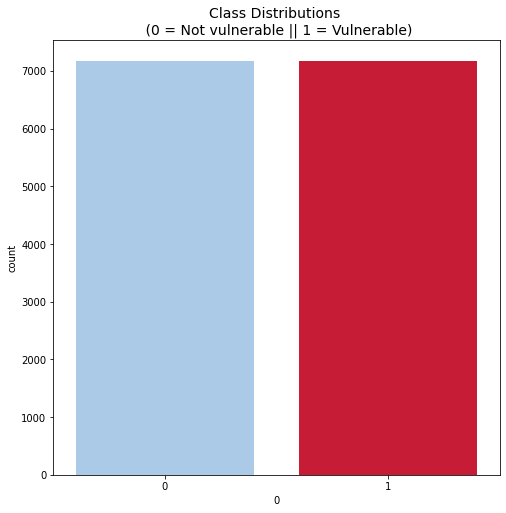

In [ ]:
import seaborn as sns
fig = plt.figure()
colors = ["#A1CAF1", "#E30022"]

sns.countplot(0, data=pd.DataFrame(entire_dataset), palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)
# fig.savefig('./figures/clean_train_unbalanced2class.png', dpi=300) #, bbox_inches='tight'

### Multiclass LSTM Model

In [ ]:
# Init
epochs = 10 #100
emb_dim = 128 #150
batch_size = 256 #512   
# labels[:2]

In [ ]:
# Clear model
import keras
keras.backend.clear_session()

In [ ]:
# Convert format for training  
ytrainres_cat = to_categorical(y_train_res, num_classes=2)
yvalres_cat = to_categorical(y_val_res, num_classes=2)
ytestres_cat = to_categorical(y_test_res, num_classes=2)

print((X_train_res.shape, ytrainres_cat.shape, X_val_res.shape, yvalres_cat.shape, X_test_res.shape, ytestres_cat.shape))

((9190, 130), (9190, 2), (2298, 130), (2298, 2), (2872, 130), (2872, 2))


In [ ]:
n_most_common_words = 1000 #150 
model = Sequential()
# n_most_common_words=Size of the vocabulary, emb_dim=Dimension of the dense embedding, input_length=Length of input sequences, when it is constant
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_train_res.shape[1]))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(64, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(2, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

import time
start_time = time.time()
# Downsampled and balanced dataset
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.0,callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])


history = model.fit(X_train_res, ytrainres_cat, epochs=epochs, batch_size=batch_size, validation_split=0.0, validation_data=(X_val_res, yvalres_cat),callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])


# history = model.fit(add_greedy_X, add_greedy_y, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

# # Entire and unbalanced dataset
# history = model.fit(under_sample_X, under_sample_y, epochs=epochs, batch_size=batch_size,validation_split=0,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

end_time = time.time()
print('Time taken for training: ', end_time-start_time)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 128)          128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 177,538
Trainable params: 177,538
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
36/36 [==============================] - 51s 763ms/step - loss: 0.6336 - acc: 0.7080 - val_loss: 0.4061 - val_acc: 0.8368
Epoch 2/10
36/36 [==============================] - 26s 730ms/step - loss: 0.3325 - acc: 0.8637 - val_loss: 0.

### Test and evaluate model accuracy

In [ ]:
accr = model.evaluate(X_test_res, ytestres_cat)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

90/90 [==============================] - 2s 24ms/step - loss: 1.0208 - acc: 0.7336
Test set
  Loss: 1.0208
  Accuracy: 0.7336


In [ ]:
y_pred = model.predict_classes(X_test_res, batch_size=32, verbose=1)
#np.argmax(model.predict(X_test_res), axis=-1)
ytest_true = y_test_res

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


90/90 [==============================] - 3s 24ms/step


In [ ]:
# ytest_true = y_test_res
# y_pred.shape

(2872,)

In [ ]:
from sklearn.metrics import average_precision_score

# Compute the average precision score
average_precision = average_precision_score(ytest_true, y_pred)
print('Average Precision Score: {:0.4f}\n'.format(average_precision))

Average Precision Score: 0.7139



In [ ]:
from sklearn.metrics import precision_recall_curve
#from sklearn.utils.fixes import signature
!pip install funcsigs
from funcsigs import signature

precision, recall, _ = precision_recall_curve(ytest_true, y_pred)
print(recall[1])
print('Recall Score: {:0.4f}\n'.format(recall[1]))



0.5146239554317549
Recall Score: 0.5146



In [ ]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

Accuracy: 0.7336350974930362
Recall: 0.5146239554317549
Precision: 0.9157372986369269
F1 score: 0.6589389210878289

 clasification report:
               precision    recall  f1-score   support

           0       0.66      0.95      0.78      1436
           1       0.92      0.51      0.66      1436

    accuracy                           0.73      2872
   macro avg       0.79      0.73      0.72      2872
weighted avg       0.79      0.73      0.72      2872


 confusion matrix:
 [[1368   68]
 [ 697  739]]


# Plot Performance

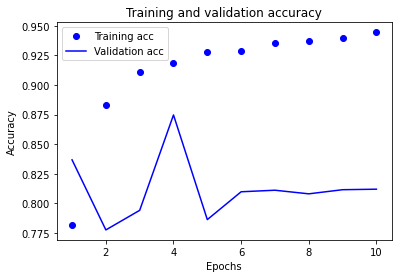

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# fig.savefig('clean_train_acc.png',dpi=300)

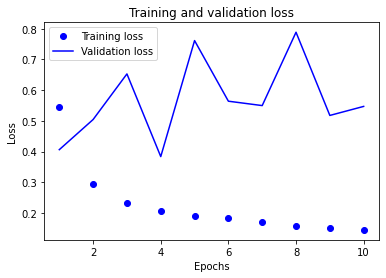

In [ ]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# fig.savefig('clean_train_loss.png',dpi=300)

In [ ]:
 model.predict(X_test, verbose=1)

48/48 [==============================] - 1s 24ms/step


array([[0.02825305, 0.9656901 ],
       [0.02825305, 0.9656901 ],
       [0.53578347, 0.47048008],
       ...,
       [0.64308333, 0.3319705 ],
       [0.07026994, 0.9226099 ],
       [0.07683176, 0.91623694]], dtype=float32)